# Problema 8 - Capítulo 8 ISLP
# Alumno: Jesus Alexis Lopez Luque
## Predicción de Sales usando Árboles de Regresión y Métodos Relacionados
### Dataset: Carseats

En este problema se predice `Sales` (variable cuantitativa) usando árboles de regresión y métodos ensemble.

## Configuración Inicial y Carga de Datos

In [44]:
# Librerías necesarias
from ISLP import load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Configuración de gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [45]:
# Cargar datos
Carseats = load_data("Carseats")
print("Dimensiones del dataset:", Carseats.shape)
print("\nPrimeras filas:")
Carseats.head()

Dimensiones del dataset: (400, 11)

Primeras filas:


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [46]:
# Descripción estadística
Carseats.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [47]:
# Preparar los datos - Convertir variables categóricas
Carseats_encoded = pd.get_dummies(Carseats, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

# Separar X e y
X = Carseats_encoded.drop('Sales', axis=1)
y = Carseats_encoded['Sales']

print("Variables predictoras:")
print(X.columns.tolist())

Variables predictoras:
['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_Yes', 'US_Yes']


---
## Inciso (a): División en Training y Test Set

**Objetivo:** Dividir el dataset en conjunto de entrenamiento y prueba.

In [48]:
# División 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} observaciones")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} observaciones")
print(f"\nProporción: 80% training, 20% test")

Tamaño del conjunto de entrenamiento: 320 observaciones
Tamaño del conjunto de prueba: 80 observaciones

Proporción: 80% training, 20% test


---
## Inciso (b): Árbol de Regresión

**Objetivo:** Ajustar un árbol de regresión, graficarlo, interpretar resultados y calcular Test MSE.

In [49]:
# Ajustar árbol de regresión
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

# Predicciones y MSE
y_pred_tree = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)

print(f"Profundidad del árbol: {tree_reg.get_depth()}")
print(f"Número de hojas: {tree_reg.get_n_leaves()}")
print(f"\n*** Test MSE: {mse_tree:.4f} ***")
print(f"*** Test RMSE: {rmse_tree:.4f} ***")

Profundidad del árbol: 16
Número de hojas: 320

*** Test MSE: 6.1789 ***
*** Test RMSE: 2.4857 ***


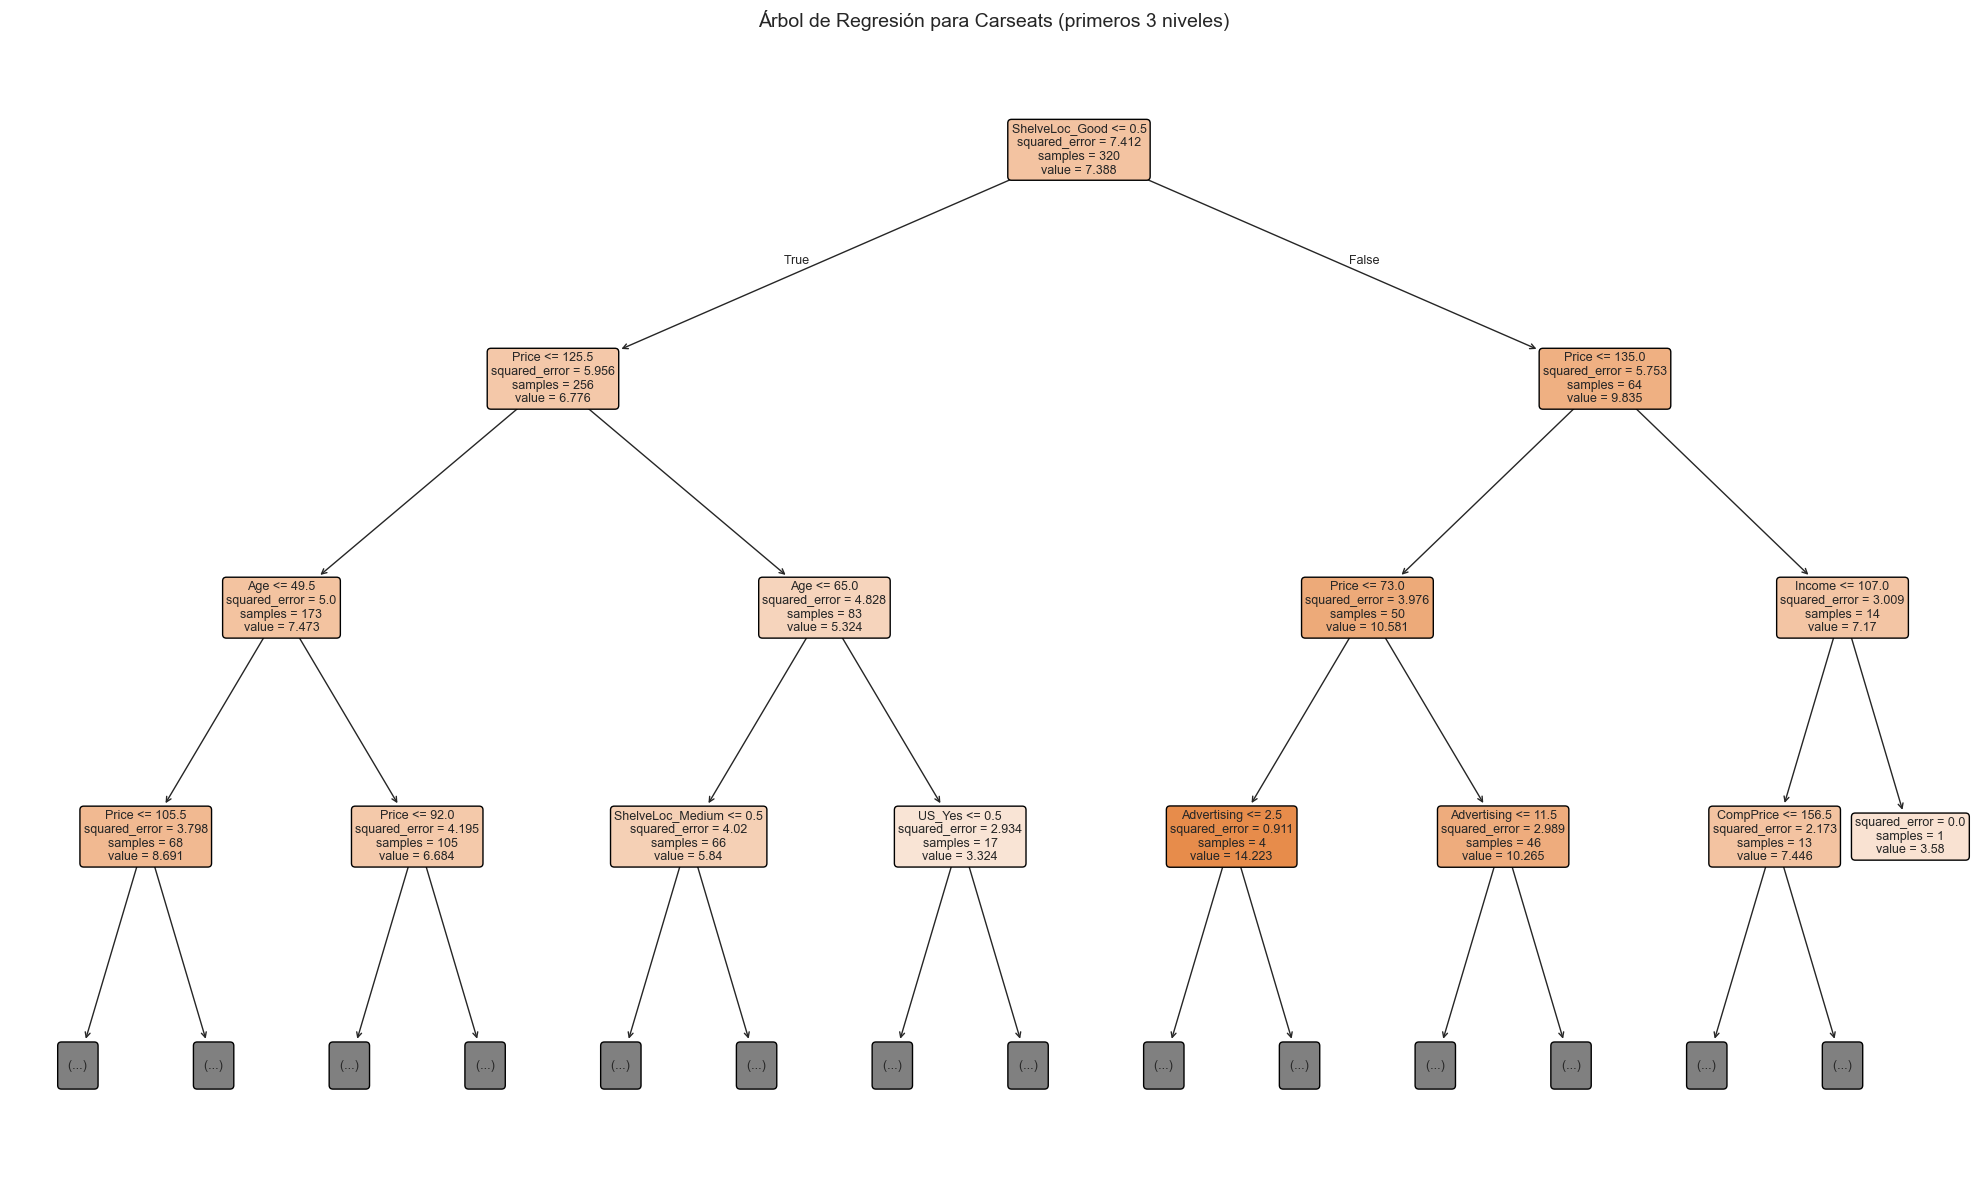

In [50]:
# Graficar el árbol (primeros 3 niveles para visualización)
plt.figure(figsize=(20, 12))
plot_tree(tree_reg, feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=9, max_depth=3)
plt.title("Árbol de Regresión para Carseats (primeros 3 niveles)", fontsize=14)
plt.tight_layout()
plt.show()

### Interpretación del Árbol:

- **ShelveLoc** (ubicación en estantes) es la variable más importante para la primera división
- Los productos con buena ubicación (`ShelveLoc_Good`) tienden a tener mayores ventas
- **Price** es un factor importante en las divisiones subsecuentes
- Un precio más bajo generalmente se asocia con mayores ventas

---
## Inciso (c): Cross-Validation y Poda del Árbol

**Objetivo:** Usar cross-validation para determinar el nivel óptimo de complejidad. ¿Mejora la poda el Test MSE?

In [51]:
# Definir los hiperparámetros a buscar con GridSearchCV
# ccp_alpha: parámetro de poda (cost complexity pruning)
# max_depth: profundidad máxima del árbol

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, None],  # None = sin límite
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]
}

print("Parámetros a evaluar:")
print(f"  - max_depth: {param_grid['max_depth']}")
print(f"  - ccp_alpha: {param_grid['ccp_alpha']}")
print(f"\nTotal de combinaciones: {len(param_grid['max_depth']) * len(param_grid['ccp_alpha'])}")

Parámetros a evaluar:
  - max_depth: [2, 3, 4, 5, 6, 7, 8, 10, 12, 15, None]
  - ccp_alpha: [0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]

Total de combinaciones: 99


In [52]:
# Ejecutar GridSearchCV
tree_cv = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=tree_cv,
    param_grid=param_grid,
    cv=5,                          # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,                     # Usar todos los núcleos
    verbose=1
)

grid_search.fit(X_train, y_train)

# Mejores parámetros
print("\n" + "="*50)
print("RESULTADOS DE GRIDSEARCHCV")
print("="*50)
print(f"\nMejores hiperparámetros encontrados:")
print(f"  - max_depth: {grid_search.best_params_['max_depth']}")
print(f"  - ccp_alpha: {grid_search.best_params_['ccp_alpha']}")
print(f"\nMejor MSE (CV): {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 99 candidates, totalling 495 fits

RESULTADOS DE GRIDSEARCHCV

Mejores hiperparámetros encontrados:
  - max_depth: 10
  - ccp_alpha: 0.03

Mejor MSE (CV): 4.9175


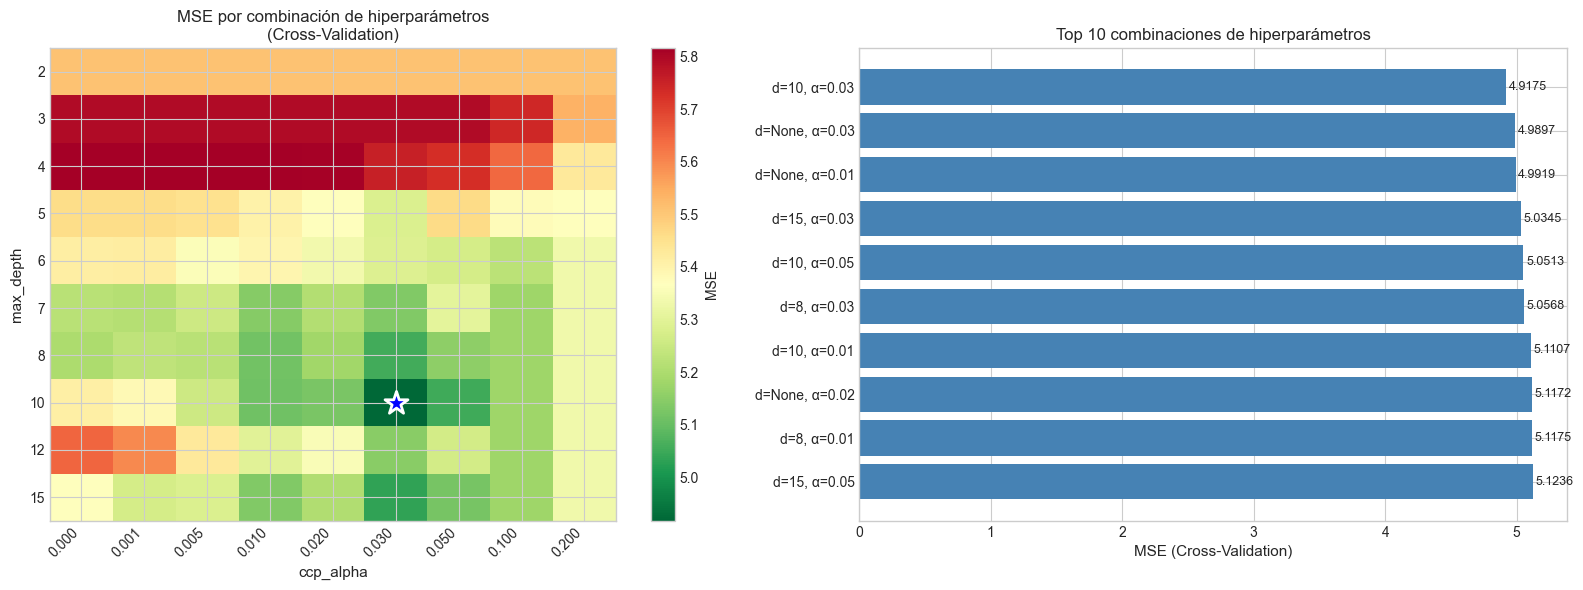

In [53]:
# Visualizar resultados del GridSearch
results = pd.DataFrame(grid_search.cv_results_)

# Crear matriz de MSE para heatmap
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_ccp_alpha',
    aggfunc='mean'
)
pivot_table = -pivot_table  # Convertir a MSE positivo

# Gráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap de MSE
import matplotlib.colors as mcolors
im = axes[0].imshow(pivot_table.values, cmap='RdYlGn_r', aspect='auto')
axes[0].set_xticks(range(len(pivot_table.columns)))
axes[0].set_xticklabels([f'{x:.3f}' for x in pivot_table.columns], rotation=45, ha='right')
axes[0].set_yticks(range(len(pivot_table.index)))
axes[0].set_yticklabels([str(x) for x in pivot_table.index])
axes[0].set_xlabel('ccp_alpha', fontsize=11)
axes[0].set_ylabel('max_depth', fontsize=11)
axes[0].set_title('MSE por combinación de hiperparámetros\n(Cross-Validation)', fontsize=12)
plt.colorbar(im, ax=axes[0], label='MSE')

# Marcar el mejor resultado
best_depth_idx = list(pivot_table.index).index(grid_search.best_params_['max_depth'])
best_alpha_idx = list(pivot_table.columns).index(grid_search.best_params_['ccp_alpha'])
axes[0].scatter(best_alpha_idx, best_depth_idx, marker='*', s=300, c='blue', edgecolors='white', linewidths=2)

# Gráfico de barras con los 10 mejores
top_10 = results.nsmallest(10, 'rank_test_score')
labels = [f"d={r['param_max_depth']}, α={r['param_ccp_alpha']}" for _, r in top_10.iterrows()]
mses = -top_10['mean_test_score'].values

axes[1].barh(range(len(labels)), mses, color='steelblue')
axes[1].set_yticks(range(len(labels)))
axes[1].set_yticklabels(labels)
axes[1].set_xlabel('MSE (Cross-Validation)', fontsize=11)
axes[1].set_title('Top 10 combinaciones de hiperparámetros', fontsize=12)
axes[1].invert_yaxis()

for i, v in enumerate(mses):
    axes[1].text(v + 0.02, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [54]:
# Ajustar árbol con los mejores hiperparámetros
best_tree = grid_search.best_estimator_

# Predicciones con el mejor modelo
y_pred_pruned = best_tree.predict(X_test)
mse_pruned = mean_squared_error(y_test, y_pred_pruned)

print("="*60)
print("COMPARACIÓN DE RESULTADOS")
print("="*60)
print(f"\nÁrbol Original (sin restricciones):")
print(f"  - Profundidad: {tree_reg.get_depth()}")
print(f"  - Hojas: {tree_reg.get_n_leaves()}")
print(f"  - Test MSE: {mse_tree:.4f}")

print(f"\nÁrbol Optimizado (GridSearchCV):")
print(f"  - max_depth: {grid_search.best_params_['max_depth']}")
print(f"  - ccp_alpha: {grid_search.best_params_['ccp_alpha']}")
print(f"  - Profundidad real: {best_tree.get_depth()}")
print(f"  - Hojas: {best_tree.get_n_leaves()}")
print(f"  - Test MSE: {mse_pruned:.4f}")

# Comparación
print("\n" + "="*60)
if mse_pruned < mse_tree:
    mejora = ((mse_tree - mse_pruned) / mse_tree) * 100
    print(f"✓ El árbol optimizado MEJORA el Test MSE en {mse_tree - mse_pruned:.4f}")
    print(f"  Mejora porcentual: {mejora:.2f}%")
else:
    print(f"✗ El árbol optimizado NO mejora el Test MSE")
    print(f"  Diferencia: {mse_pruned - mse_tree:.4f}")

COMPARACIÓN DE RESULTADOS

Árbol Original (sin restricciones):
  - Profundidad: 16
  - Hojas: 320
  - Test MSE: 6.1789

Árbol Optimizado (GridSearchCV):
  - max_depth: 10
  - ccp_alpha: 0.03
  - Profundidad real: 8
  - Hojas: 41
  - Test MSE: 5.3113

✓ El árbol optimizado MEJORA el Test MSE en 0.8676
  Mejora porcentual: 14.04%


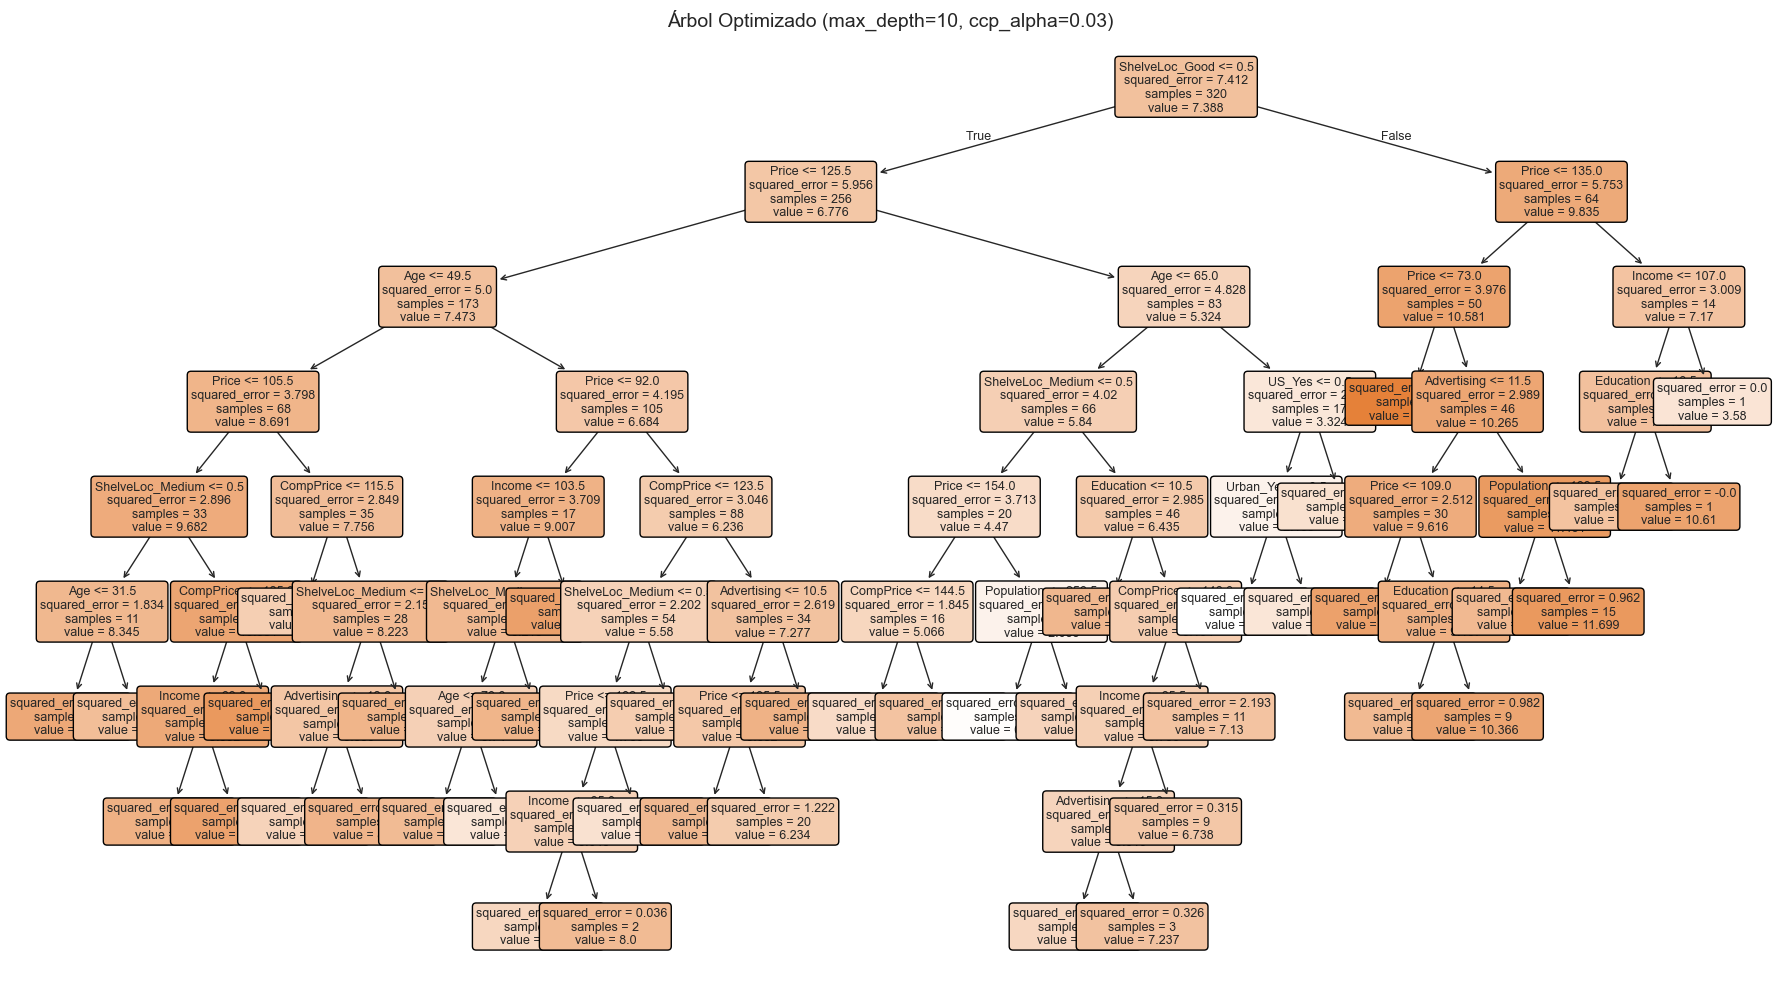


El árbol optimizado tiene 41 hojas vs 320 del original


In [55]:
# Visualizar el árbol optimizado
plt.figure(figsize=(18, 10))
plot_tree(best_tree, feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=9)
plt.title(f"Árbol Optimizado (max_depth={grid_search.best_params_['max_depth']}, ccp_alpha={grid_search.best_params_['ccp_alpha']})", fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nEl árbol optimizado tiene {best_tree.get_n_leaves()} hojas vs {tree_reg.get_n_leaves()} del original")


---
## Inciso (d): Bagging

**Objetivo:** Usar bagging, calcular Test MSE y determinar variables más importantes con `feature_importance_`.

In [56]:
# Bagging (Random Forest con max_features = todos los predictores)
rf_bagging = RandomForestRegressor(
    n_estimators=500, 
    max_features=None,  # Usar todas las variables = Bagging
    random_state=42, 
    n_jobs=-1
)
rf_bagging.fit(X_train, y_train)

y_pred_bagging = rf_bagging.predict(X_test)
mse_bagging = mean_squared_error(y_test, y_pred_bagging)

print(f"Número de árboles: 500")
print(f"\n*** Test MSE (Bagging): {mse_bagging:.4f} ***")
print(f"*** Test RMSE (Bagging): {np.sqrt(mse_bagging):.4f} ***")

Número de árboles: 500

*** Test MSE (Bagging): 3.0509 ***
*** Test RMSE (Bagging): 1.7467 ***


In [57]:
# Importancia de variables
feature_importance_bagging = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf_bagging.feature_importances_
}).sort_values('Importancia', ascending=False)

print("Importancia de Variables (Bagging):")
print("="*40)
feature_importance_bagging

Importancia de Variables (Bagging):


,Variable,Importancia
4,Price,0.314443
7,ShelveLoc_Good,0.197284
5,Age,0.117424
0,CompPrice,0.094673
2,Advertising,0.082258
8,ShelveLoc_Medium,0.058050
1,Income,0.052602
3,Population,0.040865
6,Education,0.030047
9,Urban_Yes,0.006692


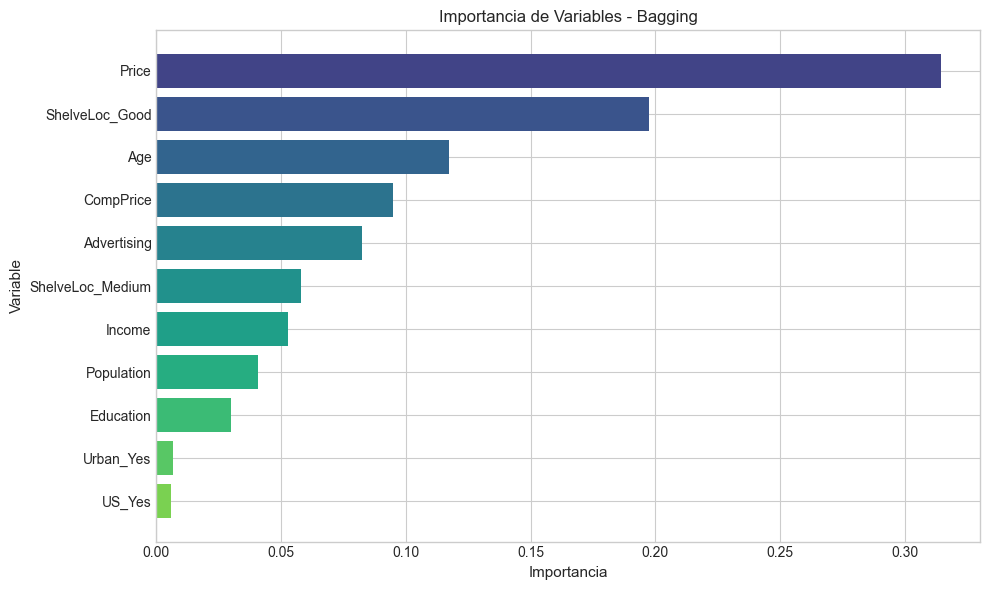

In [58]:
# Graficar importancia de variables
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance_bagging)))
plt.barh(feature_importance_bagging['Variable'], feature_importance_bagging['Importancia'], color=colors)
plt.xlabel('Importancia', fontsize=11)
plt.ylabel('Variable', fontsize=11)
plt.title('Importancia de Variables - Bagging', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Interpretación:
- **ShelveLoc_Good** y **Price** son las variables más importantes
- La ubicación en estantes tiene un impacto significativo en las ventas
- El precio es un factor determinante en la decisión de compra

---
## Inciso (e): Random Forests

**Objetivo:** Usar Random Forests, calcular Test MSE, importancia de variables y describir el efecto de *m* (número de variables por split).

In [59]:
# Evaluar diferentes valores de m (max_features)
n_features = X_train.shape[1]
m_values = [2, 3, 4, 5, 6, int(np.sqrt(n_features)), n_features//2, n_features]
m_values = sorted(list(set(m_values)))  # Eliminar duplicados

results_rf = []

print(f"Número total de predictores: {n_features}")
print(f"\nEfecto de m (max_features) en el Test MSE:")
print("="*40)

for m in m_values:
    rf = RandomForestRegressor(n_estimators=500, max_features=m, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    results_rf.append({'m': m, 'MSE': mse_rf})
    print(f"m = {m:2d}: Test MSE = {mse_rf:.4f}")

# Mejor m
best_result = min(results_rf, key=lambda x: x['MSE'])
print(f"\n✓ Mejor m: {best_result['m']} con Test MSE: {best_result['MSE']:.4f}")

Número total de predictores: 11

Efecto de m (max_features) en el Test MSE:
m =  2: Test MSE = 4.4419
m =  3: Test MSE = 3.7528
m =  4: Test MSE = 3.4433
m =  5: Test MSE = 3.2766
m =  6: Test MSE = 3.2302
m = 11: Test MSE = 3.0509

✓ Mejor m: 11 con Test MSE: 3.0509


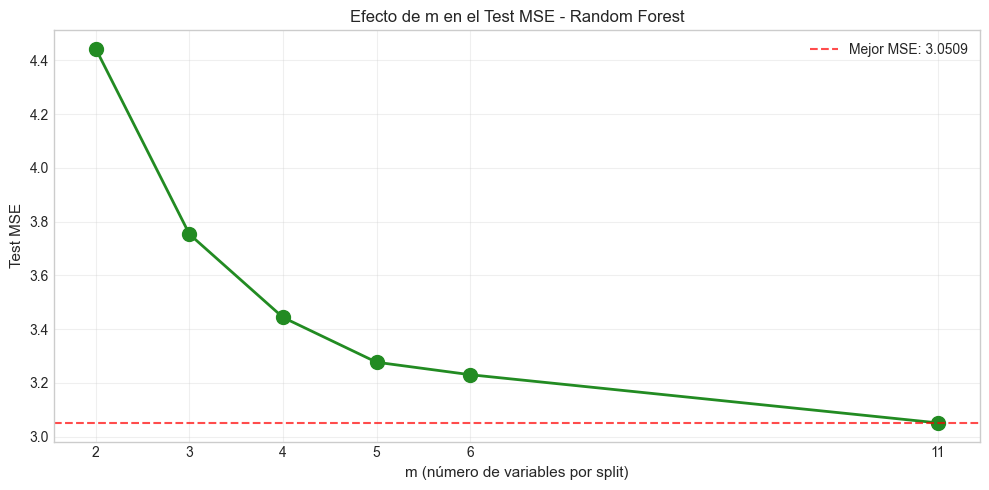

In [60]:
# Graficar efecto de m
m_list = [r['m'] for r in results_rf]
mse_list = [r['MSE'] for r in results_rf]

plt.figure(figsize=(10, 5))
plt.plot(m_list, mse_list, marker='o', linewidth=2, markersize=10, color='forestgreen')
plt.axhline(y=best_result['MSE'], color='red', linestyle='--', alpha=0.7, label=f'Mejor MSE: {best_result["MSE"]:.4f}')
plt.xlabel('m (número de variables por split)', fontsize=11)
plt.ylabel('Test MSE', fontsize=11)
plt.title('Efecto de m en el Test MSE - Random Forest', fontsize=12)
plt.xticks(m_list)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
# Random Forest con el mejor m
rf_best = RandomForestRegressor(n_estimators=500, max_features=best_result['m'], random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Importancia de variables
feature_importance_rf = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf_best.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"Importancia de Variables (Random Forest, m={best_result['m']}):")
print("="*50)
feature_importance_rf

Importancia de Variables (Random Forest, m=11):


,Variable,Importancia
4,Price,0.314443
7,ShelveLoc_Good,0.197284
5,Age,0.117424
0,CompPrice,0.094673
2,Advertising,0.082258
8,ShelveLoc_Medium,0.058050
1,Income,0.052602
3,Population,0.040865
6,Education,0.030047
9,Urban_Yes,0.006692


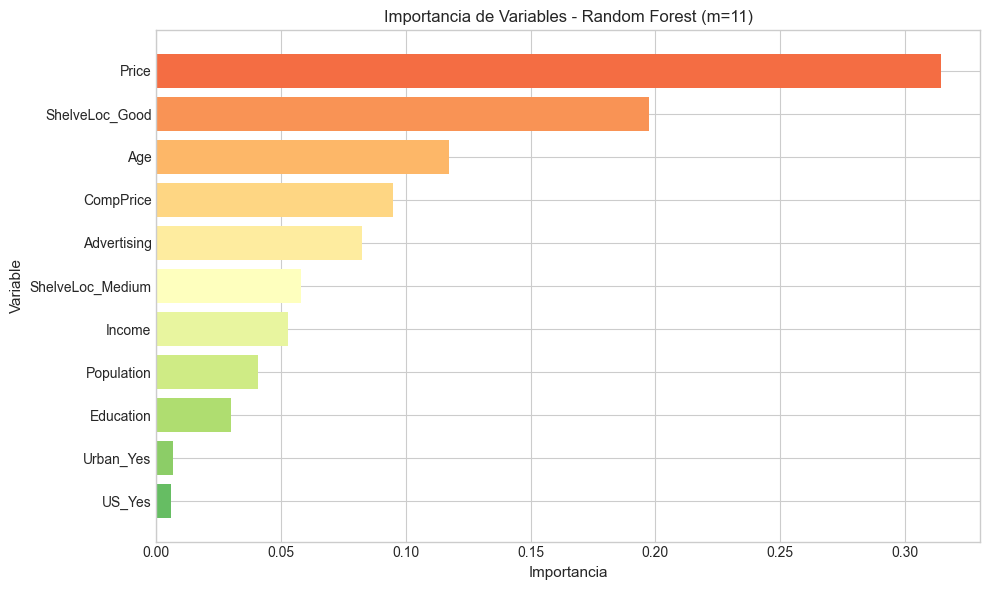

In [62]:
# Graficar importancia
plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance_rf)))
plt.barh(feature_importance_rf['Variable'], feature_importance_rf['Importancia'], color=colors)
plt.xlabel('Importancia', fontsize=11)
plt.ylabel('Variable', fontsize=11)
plt.title(f'Importancia de Variables - Random Forest (m={best_result["m"]})', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Análisis del efecto de m:

- **Valores pequeños de m** reducen la correlación entre árboles, lo que disminuye la varianza del ensemble
- **Valores muy pequeños** pueden no capturar predictores importantes en cada split
- El **valor óptimo** balancea varianza y sesgo
- Para problemas de **regresión**, se recomienda m ≈ p/3

---
## Inciso (f): BART (Bayesian Additive Regression Trees)

**Objetivo:** Analizar los datos usando BART y reportar resultados.



### Nota Técnica: Conversión a Float para BART

**¿Por qué convertir a float?**

BART (Bayesian Additive Regression Trees) utiliza internamente la función `np.isnan()` de NumPy para detectar valores faltantes. Esta función **solo acepta arrays de tipo float**.

**Problema encontrado:**
- Al usar `pd.get_dummies()`, las variables categóricas se convierten en columnas booleanas (`True`/`False`)
- Estas columnas tienen tipo `bool` o `uint8`
- `np.isnan()` no puede procesar tipos booleanos, generando un `TypeError`

**Solución:**
- Convertir explícitamente `X_train` y `X_test` a tipo `float` con `.astype(float)`
- Esto transforma: `True → 1.0`, `False → 0.0`
- El modelo funciona igual, pero ahora es compatible con las verificaciones internas de BART


In [63]:

from ISLP.bart import BART
    
# Convertir a float para compatibilidad con BART
# BART requiere que todos los datos sean de tipo float
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)
    
bart = BART(random_state=42)
bart.fit(X_train_float, y_train)
    
y_pred_bart = bart.predict(X_test_float)
mse_bart = mean_squared_error(y_test, y_pred_bart)
    
print(f"*** Test MSE (BART): {mse_bart:.4f} ***")
print(f"*** Test RMSE (BART): {np.sqrt(mse_bart):.4f} ***")
    


*** Test MSE (BART): 1.1784 ***
*** Test RMSE (BART): 1.0855 ***


---
## Resumen de Resultados

In [64]:
# Tabla resumen
print("="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
print(f"\n{'Método':<30} {'Test MSE':<12} {'Test RMSE':<12}")
print("-" * 54)
print(f"{'Árbol de Regresión':<30} {mse_tree:<12.4f} {np.sqrt(mse_tree):<12.4f}")
print(f"{'Árbol Podado (CV)':<30} {mse_pruned:<12.4f} {np.sqrt(mse_pruned):<12.4f}")
print(f"{'Bagging':<30} {mse_bagging:<12.4f} {np.sqrt(mse_bagging):<12.4f}")
print(f"{'Random Forest (m=' + str(best_result['m']) + ')':<30} {best_result['MSE']:<12.4f} {np.sqrt(best_result['MSE']):<12.4f}")

try:
    print(f"{'BART':<30} {mse_bart:<12.4f} {np.sqrt(mse_bart):<12.4f}")
except:
    print(f"{'Gradient Boosting':<30} {mse_gb:<12.4f} {np.sqrt(mse_gb):<12.4f}")

RESUMEN DE RESULTADOS

Método                         Test MSE     Test RMSE   
------------------------------------------------------
Árbol de Regresión             6.1789       2.4857      
Árbol Podado (CV)              5.3113       2.3046      
Bagging                        3.0509       1.7467      
Random Forest (m=11)           3.0509       1.7467      
BART                           1.1784       1.0855      


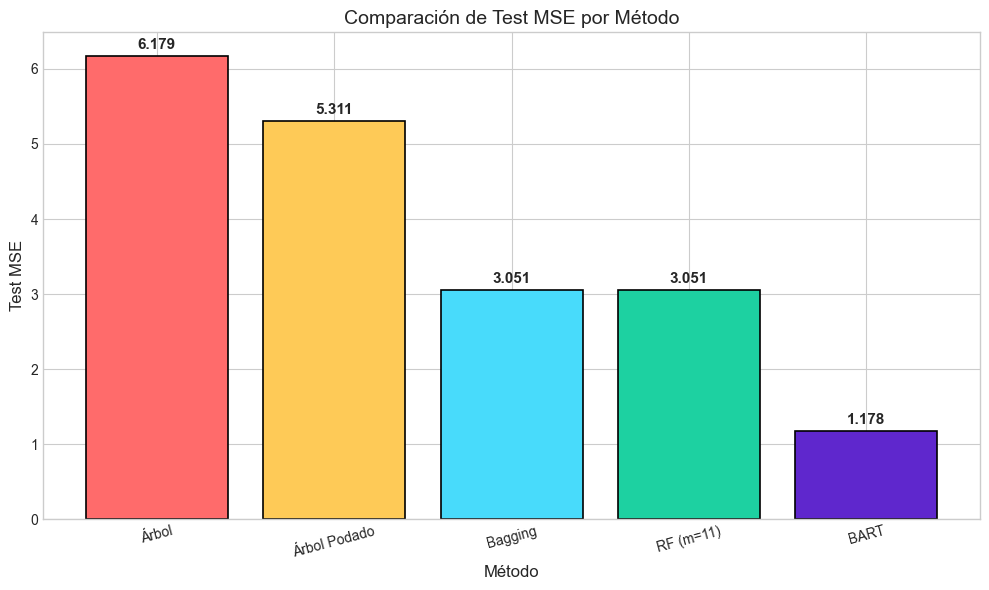

In [65]:
# Gráfico comparativo    
metodos = ['Árbol', 'Árbol Podado', 'Bagging', f'RF (m={best_result["m"]})', 'BART']
mses = [mse_tree, mse_pruned, mse_bagging, best_result['MSE'], mse_bart]


plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1', '#5f27cd']
bars = plt.bar(metodos, mses, color=colors, edgecolor='black', linewidth=1.2)

# Añadir valores sobre las barras
for bar, mse in zip(bars, mses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{mse:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Método', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.title('Comparación de Test MSE por Método', fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

---
## Conclusiones

1. **Árbol de regresión simple:** Tiene el MSE más alto debido a su alta varianza

2. **Poda (Cross-Validation):** Puede reducir ligeramente el MSE al evitar overfitting

3. **Bagging:** Reduce significativamente el MSE al promediar múltiples árboles

4. **Random Forest:** Generalmente produce el mejor resultado al decorrelacionar los árboles

5. **BART:** Métodos avanzados que también producen buenos resultados

### Variables más importantes:
- **ShelveLoc** (ubicación en estantes) - factor más influyente
- **Price** - segundo factor más importante
- **CompPrice** - precio de competidores
- **Age** - edad promedio de la población local